In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

# A comment

from __future__ import (print_function, division, absolute_import)

import os
import glob
import copy
import sys
import warnings

import numpy as np
np.set_printoptions(threshold='nan')

# Matplotlib related
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cmaps
plt.rc('text', usetex=False)

from astropy.table import \
    Table, \
    Column, \
    vstack, \
    hstack, \
    unique
    
from astropy.utils.metadata import MergeConflictWarning
warnings.filterwarnings('ignore', category=MergeConflictWarning, 
                        append=True)
from astropy import units as u
from astropy.coordinates import SkyCoord as sc
from astropy.utils.console import ProgressBar
from astropy import visualization as vs
from astropy.io import fits

import statistics as stat

import palettable as pal
from palettable.colorbrewer.diverging import BrBG_4_r

plt.rcParams['figure.figsize'] = (12, 7)

# Create Visual Comparing DECaLs  and HSC

In [2]:
table_hsc = Table.read('hsc_s16a_fastlane_g09_short_full_rband.fits', format = 'fits')
table_decals = Table.read ('decals_dr3_g09_short.fits', format = 'fits')

table_hsc.sort('rcmodel_mag')
table_decals.sort('rmag_decal')

ra_hsc = table_hsc['ra']
dec_hsc = table_hsc['dec']
ra_decals = table_decals['RA']
dec_decals = table_decals['DEC']


In [3]:
"""
Absolute magnitude of the Sun in HSC filters
Right now, just use the DES filters
"""
SUN_G = 5.08
SUN_R = 4.62
SUN_I = 4.52
SUN_Z = 4.52
SUN_Y = 4.51

from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import Distance

# Setup the default cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def luminosity2mag(luminosity, redshift, absmag_sun):
    """
    Convert the luminosity back to absolute magnitude: 
        absmag = absmag_sun - (2.5 * luminosity)
    
    Use redshift to estimate the distance modulus under 
    assumed cosmology.
    More on this topic please read: https://en.wikipedia.org/wiki/Distance_modulus
    
    Here we use the FlatLambdaCDM cosmology, assuming 
        Hubble constant: H0 = 70 km/s/Mpc; 
        Mass density parameter: Omega_m = 0.3
    
    Then convert the absolute magnitude back to apparent
    magnitude:
        mag = absmag + distmod 
    """
    
    # Convert luminosity into absolute magnitude with the 
    # help of the absolute magnitude of Sun in this filter
    absmag = absmag_sun - (2.5 * luminosity) 
    
    # Estimate the distance modulus given redshift 
    # and convert the absolute magnitude back to apparent one
    return (absmag + 
            Distance(z=redshift, cosmology=cosmo).distmod.value)
    
"""
The luminosity2mag() function should work with array
So using the current table, you should be able to convert 
the luminosity within 100 kpc: `lum_100` into magnitude using
"""
mag_r_100kpc = luminosity2mag(table_hsc['lum_100_r'], 
                              table_hsc['z_best'], 
                              SUN_R)

"""
This magnitude has been corrected for Galactic extinction.
You do not need to do that again. 

We should have used mag_r_100, but since we do not have them 
right now, let's use the CModel (r-i) color to convert the 
i-band magnitude into r-band magnitude first. 

Color here describes the magnitude difference between two filters: 
    (g-i)_cmodel = gcmodel_mag - icmodel_mag

For massive galaxies in this sample, their spectral energy
distributions (SED) are quite similar, and using a simple 
color conversion is not a terrible idea.  
""" 
    
table_hsc.add_column(mag_r_100kpc, name='mag_r_100kpc')
# Then you can use this magnitude for comparison.

In [4]:
hsc = sc(ra=ra_hsc*u.degree, dec=dec_hsc*u.degree)  
decals = sc(ra=ra_decals*u.degree, dec=dec_decals*u.degree)  
idx, d2d, d3d = hsc.match_to_catalog_sky(decals)

In [5]:
#d2d  cut
idx_use = np.asarray(d2d.to(u.arcsec))<=1.0

In [6]:
#merge catalogs and apply d2d cut
table_merge = hstack([table_hsc, table_decals[idx]])
table_use = table_merge[idx_use]

In [7]:
#get columns into useful arrays, accounting for error
r_hsc = table_use['mag_r_100kpc']
r_decal = table_use['rmag_decal'] - table_use['a_r_decal']

#apply difference in filter response curve
r_hsc_corr = [x-0.07 for x in r_hsc]

#get magnitude differences and stellar masses
r_diff = r_hsc_corr - r_decal 
lambda_redm = table_use['lambda_redm']
BCG = [x>0 for x in lambda_redm]

In [8]:
#split into two redshift bins
hsc_z = table_use['z_best']

In [9]:
#only graph galaxies with mass > 11.5
cut_idx = [x>11.5 for x in table_use['logm_100']]

In [10]:
#label arrays
xx = r_hsc[cut_idx]
yy = r_diff[cut_idx]
cc = np.array(BCG)[cut_idx]
zz = hsc_z[cut_idx]

idx_finite = ((np.isfinite(xx)) & np.isfinite(yy) & np.isfinite(zz))

xx_use = xx[idx_finite]
yy_use = yy[idx_finite]
zz_use = zz[idx_finite]
#cc_use = cc[idx_finite]

In [11]:
# set redshift bins
idx_1 = (zz_use < .4)
idx_2 = (zz_use >.4)

In [12]:
cc_use = [cc[i] for i in range(len(cc)) if (idx_finite[i])]
c_1 = [cc_use[i] for i in range(len(cc_use)) if (zz_use[i]<.4)]
c_2 = [cc_use[i] for i in range(len(cc_use)) if (zz_use[i]>.4)]

#set colors for graphs
c = 'darkblue'
c_k = BrBG_4_r.get_mpl_colormap()

/Users/danecross/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/danecross/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


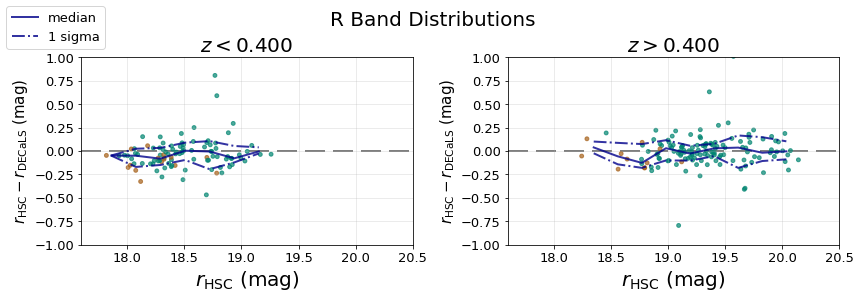

In [13]:
fig, axarr = plt.subplots(1,2)
#fig.subplots_adjust(hspace=0.5)

total_bins = 10

"""plot redshift bin 1"""
axarr[0].scatter(xx_use[idx_1], yy_use[idx_1],
                   c=c_1,
                   label='_nolegend_',
                   cmap=c_k, 
                   alpha=0.7, s=15)
axarr[0].set_title(r'$z < 0.400$', 
                     fontsize=20)

#plot runing median and +/- 1 sigma
bins = np.linspace(xx_use[idx_1].min(), xx_use[idx_1].max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(xx_use[idx_1], bins)

running_median = [np.median(yy_use[idx_1][idx==k]) for k in range(3,total_bins)]
running_sixteen = [np.percentile(yy_use[idx_1][idx==k], 16) for k in range(3,total_bins)]
running_eighty_four = [np.percentile(yy_use[idx_1][idx==k], 84) for k in range(3,total_bins)]
axarr[0].plot(bins[3:total_bins]-delta/2,running_median,c=c,linewidth=2.0,lw=4,alpha=.8)
axarr[0].plot(bins[3:total_bins]-delta/2 ,running_sixteen,'-.',c=c,linewidth=2.0,lw=4,alpha=.8)
axarr[0].plot(bins[3:total_bins]-delta/2 ,running_eighty_four,'-.',c=c,linewidth=2.0,lw=4,alpha=.8)

"""plot redshift bin 2"""
axarr[1].scatter(xx_use[idx_2], yy_use[idx_2],
                   c=c_2,
                   label='_nolegend_',
                   cmap=c_k, 
                   alpha=0.7, s=15)
axarr[1].set_title(r'$z > 0.400$', 
                     fontsize=20)

#set up runing median, +/- 1 sigma
bins = np.linspace(xx_use[idx_2].min(), xx_use[idx_2].max(), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(xx_use[idx_2], bins)

running_median = [np.median(yy_use[idx_2][idx==k]) for k in range(1,total_bins)]
running_sixteen = [np.percentile(yy_use[idx_2][idx==k], 16) for k in range(1,total_bins)]
running_eighty_four = [np.percentile(yy_use[idx_2][idx==k], 84) for k in range(1,total_bins)]
axarr[1].plot(bins[1:total_bins]-delta/2 ,running_median,c=c,linewidth=2.0,lw=4,alpha=.8,label='median')
axarr[1].plot(bins[1:total_bins]-delta/2 ,running_sixteen,'-.',c=c,linewidth=2.0,lw=4,alpha=.8,label='1 sigma')
axarr[1].plot(bins[1:total_bins]-delta/2 ,running_eighty_four,'-.',c=c,linewidth=2.0,lw=4,alpha=.8)




for i in range(2):
    subplot = axarr[i]
    
    subplot.set_xlim(17.6, 20.5)
    subplot.set_ylim(-1, 1)
    
    # zorder=0 puts the grid in the background
    subplot.grid(alpha=0.3, zorder=0)
    
    subplot.set_xlabel(r'$r_{\rm HSC}\ ({\rm mag})$', fontsize=20)
    subplot.set_ylabel(r'$r_{\rm HSC}-r_{\rm DECaLS}\ ({\rm mag})$', 
                       fontsize=15)
    
    subplot.axhline(0.0, linewidth=2.0, alpha=0.5, c='k', 
                    zorder=0, linestyle='--', dashes=(10, 4))
    
    for tick in subplot.xaxis.get_major_ticks():
        tick.label.set_fontsize(13) 
    for tick in subplot.yaxis.get_major_ticks():
        tick.label.set_fontsize(13) 
    
plt.suptitle('R Band Distributions\n', fontsize=20)
fig.tight_layout(rect=[0, 0.4, 1, 0.95])

handles, labels = axarr[1].get_legend_handles_labels()
fig.legend(handles=handles,labels=labels, loc=2, fontsize=13)

# Note Outliers, output to fits file

In [14]:
pos_sigma = [x for x in yy_use if x < np.percentile(yy_use, 16)]
neg_sigma = [x for x in yy_use if x > np.percentile(yy_use, 84)]

outliers = pos_sigma.append(neg_sigma)
table_merge = hstack([table_hsc, table_decals[idx]])
table_use = table_merge[idx_use]

In [15]:
table_out = table_use[cut_idx][idx_finite]
idx_b = [(x > np.percentile(yy_use, 84))or(x < np.percentile(yy_use, 16)) for x in yy_use]

r_b = table_out['ra', 'dec', 'object_id'][idx_b]
tbhdu = fits.BinTableHDU.from_columns(
     [fits.Column(name='ra', format='D', array=np.array(r_b['ra'])),
      fits.Column(name='dec', format='D', array=np.array(r_b['dec'])),
      fits.Column(name='object_id', format = 'K', array=np.array(r_b['object_id']))])
tbhdu.writeto('_r_b.fits')